# Upload dataset
https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

In [7]:
# from google.colab import files
# files.upload()
# !kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
# import zipfile

# with zipfile.ZipFile("cifake-real-and-ai-generated-synthetic-images.zip", "r") as zip_ref:
#     zip_ref.extractall("/content/cifake")  # Extract dataset here
data_dir_train = "/content/cifake/train"
data_dir_test = "/content/cifake/test"

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 82% 86.0M/105M [00:00<00:00, 183MB/s]
100% 105M/105M [00:00<00:00, 190MB/s] 


https://www.tensorflow.org/tutorials/load_data/images

In [8]:
import numpy as np
import tensorflow as tf

## Train Dataset

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Path to the directory containing 'FAKE' and 'REAL'
    label_mode="binary",  # If there are only two classes (FAKE/REAL)
    image_size=(32, 32),  # Resize images to 32x32
    batch_size=32,  # Batch size for training
)

Found 100000 files belonging to 2 classes.


In [10]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Batch shape: (32, 32, 32, 3)
Labels shape: (32, 1)


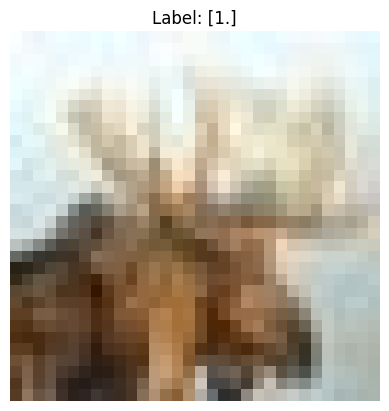

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Show the shape of the data
print("Batch shape:", image_batch.shape)  # (batch_size, height, width, channels)
print("Labels shape:", label_batch.shape)  # (batch_size,)

# Display the first image in the batch
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title(f"Label: {label_batch[0].numpy()}")
plt.axis("off")
plt.show()

In [12]:
print("Class names:", train_ds.class_names)

Class names: ['FAKE', 'REAL']


Image batch shape: (32, 32, 32, 3)
Label batch shape: (32, 1)


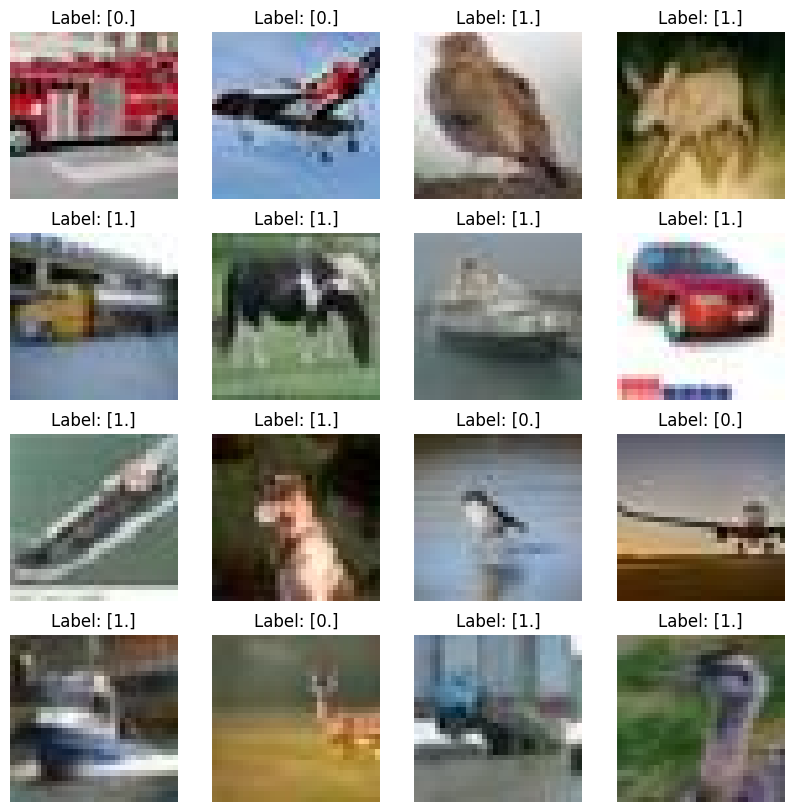

In [13]:
for images, labels in train_ds.take(1):  # Take only 1 batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    # Show multiple images from the batch
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.set_title(f"Label: {labels[i].numpy()}")
        ax.axis("off")

    plt.show()

## Test Dataset

In [14]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,  # Path to the directory containing 'FAKE' and 'REAL'
    label_mode="binary",  # If there are only two classes (FAKE/REAL)
    image_size=(32, 32),  # Resize images to 32x32
    batch_size=32,  # Batch size for training
)

Found 20000 files belonging to 2 classes.


In [15]:
print("Class names:", test_ds.class_names)

Class names: ['FAKE', 'REAL']


# Iterate on your CNN architecture using your small training set

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization

def initialize_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32,32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))


    return model

In [23]:
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.losses import BinaryCrossentropy


def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", Precision(), Recall(), AUC()]
    )
    return model


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
es = EarlyStopping(patience = 15, monitor ='val_loss', restore_best_weights=True)

In [25]:
model = initialize_model()
model = compile_model(model)
history = model.fit(train_ds, validation_data=test_ds, epochs = 100, batch_size = 32, callbacks = [es, lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8472 - auc_1: 0.9181 - loss: 0.3639 - precision_1: 0.8474 - recall_1: 0.8480 - val_accuracy: 0.9118 - val_auc_1: 0.9800 - val_loss: 0.2289 - val_precision_1: 0.8690 - val_recall_1: 0.9698 - learning_rate: 0.0010
Epoch 2/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9236 - auc_1: 0.9755 - loss: 0.1982 - precision_1: 0.9260 - recall_1: 0.9211 - val_accuracy: 0.9126 - val_auc_1: 0.9859 - val_loss: 0.2179 - val_precision_1: 0.8623 - val_recall_1: 0.9820 - learning_rate: 0.0010
Epoch 3/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9345 - auc_1: 0.9814 - loss: 0.1716 - precision_1: 0.9371 - recall_1: 0.9317 - val_accuracy: 0.9352 - val_auc_1: 0.9895 - val_loss: 0.1606 - val_precision_1: 0.9014 - val_recall_1: 0.9772 - learning_rate: 0.0010
Epoch 4/100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9404 - auc_1: 0.9843 - loss: 0.1568 - precision_1: 0.9422 - recall_1: 0.9386 - val_a

In [46]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 0.5)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.8, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

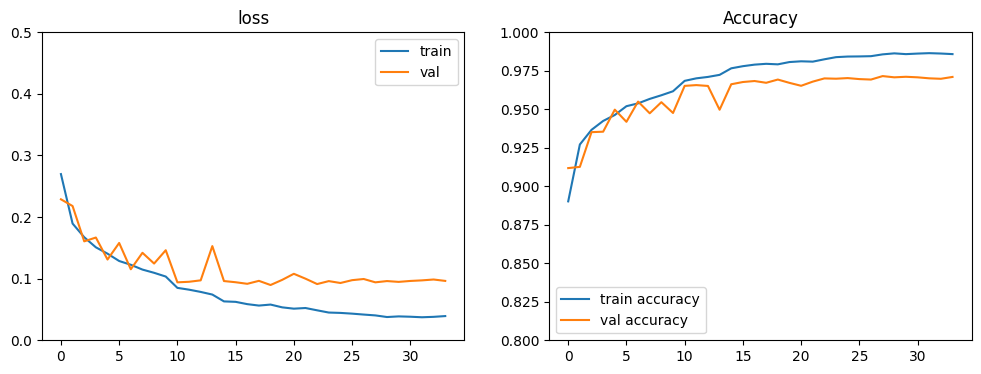

In [47]:
plot_history(history, title='', axs=None, exp_name="")

In [29]:
model.evaluate(test_ds, return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9694 - auc_1: 0.9942 - loss: 0.0907 - precision_1: 0.9620 - recall_1: 0.9766


{'accuracy': 0.9692999720573425,
 'auc_1': 0.9944639205932617,
 'loss': 0.08971163630485535,
 'precision_1': 0.9627292156219482,
 'recall_1': 0.9764000177383423}

In [30]:
# from tensorflow.keras.models import save_model
# from tensorflow.keras.models import load_model


In [40]:
# model.save('/content/baseline_image.keras')

In [41]:
# from google.colab import files
# files.download('/content/baseline_image.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
foo = load_model(r"/home/romaric/code/nghia95/fake-data-detector/notebooks/roma_utils/roma_models/baseline_image.keras")


In [45]:
foo.evaluate(test_ds,return_dict=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9690 - auc_1: 0.9942 - loss: 0.0915 - precision_1: 0.9611 - recall_1: 0.9768


{'accuracy': 0.9692999720573425,
 'auc_1': 0.9944639205932617,
 'loss': 0.08971156924962997,
 'precision_1': 0.9627292156219482,
 'recall_1': 0.9764000177383423}